In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("input.csv")

In [2]:
df

,x1,x2,sign,rhs
0,-1,1,||,min
1,-1,-2,<=,6
2,1,-2,<=,4
3,-1,1,<=,1
4,<=,<=,NaN,NaN


In [3]:
import numpy as np
import pandas as pd

class SimplexLinearProgram:
    def __init__(self, df):
        # Tìm max hay min
        optimize = df.iloc[0, -1]
        self.minimize = (optimize == "min")

        # Hàm mục tiêu
        self.c = np.array(df.iloc[0, :-2], dtype=float)
        # Hệ số ràng buộc
        self.A = np.array(df.iloc[1:-1, :-2], dtype=float)
        # Giới hạn ràng buộc
        self.b = np.array(df.iloc[1:-1, -1], dtype=float)
        # Dấu ràng buộc dt/bdt <= >= =
        self.sign_constraints = np.array(df.iloc[1:-1, -2])
        # Dấu ràng buộc biến
        self.sign_vars = np.array(df.iloc[-1, :-2])

        # Số biến, số ràng buộc
        self.num_variables = self.c.shape[0]
        self.num_constraints = self.b.shape[0]
        # Số biến cần tạo mới
        self.num_new_variable = 0

    def to_normal_form(self):
        # Chuyển hàm mục tiêu thành dạng tối thiểu hóa
        if not self.minimize:
            self.c = -self.c

        # Xử lý dấu của các biến
        for i in range(self.num_variables - self.num_new_variable):
            if self.sign_vars[i] == "<=":  # xi <= 0
                self.c[i] = -self.c[i]
                self.A[:, i] = -self.A[:, i]
                self.sign_vars[i] = ">="
            elif self.sign_vars[i] == "free":  # xi tự do
                self.num_variables += 1
                self.num_new_variable += 1
                self.c = np.append(self.c, -self.c[i])
                new_col = -np.array([self.A[:, i]]).T
                self.A = np.hstack((self.A, new_col))
                self.sign_vars[i] = ">="
                self.sign_vars = np.append(self.sign_vars, ">=")

        # Xử lý dấu của các ràng buộc
        for i in range(self.num_constraints):
            if self.sign_constraints[i] == ">=":  # >=
                self.A[i, :] = -self.A[i, :]
                self.b[i] = -self.b[i]
                self.sign_constraints[i] = "<="
            elif self.sign_constraints[i] == "=":  # =
                self.num_constraints += 1
                self.sign_constraints[i] = "<="
                new_row = -np.array([self.A[i, :]])
                self.A = np.vstack((self.A, new_row))
                self.b = np.append(self.b, -self.b[i])
                self.sign_constraints = np.append(self.sign_constraints, "<=")

    def to_table_form(self):
        # Tạo bảng
        self.to_normal_form()
        tableau = np.vstack((np.hstack((self.c, np.zeros(self.num_constraints + 1))),
                             np.hstack((self.A, np.eye(self.num_constraints), self.b.reshape(-1, 1)))))
        self.sign_vars = np.append(self.sign_vars, [">="] * self.num_constraints)
        return tableau

    def get_method(self):
        if np.any(self.b < 0):
            return 2  # 2 pha (two-phase method)
        elif np.any(self.b == 0):
            return 1  # Xoay Bland (Bland's rule)
        else:
            return 0  # Xoay đơn hình (Dantzig's rule)

    def choose_pivot(self, tableau, method):
        pivot_col, pivot_row = None, None
        if method == 'dantzig':
            # Chọn cột pivot theo phương pháp Dantzig
            pivot_col = np.argmin(tableau[0, :-1])
            if tableau[0, pivot_col] >= 0:
                return 1, pivot_row, pivot_col
            
        elif method == 'bland':
            # Chọn cột pivot theo phương pháp Bland
            for j in range(self.num_variables):
                if tableau[0, j] < 0:
                    pivot_col = j
                    break
            if pivot_col is None:
                return 1, pivot_row, pivot_col

        min_ratio = np.inf
        for i in range(1, self.num_constraints + 1):
            if tableau[i, pivot_col] > 0:
                ratio = tableau[i, -1] / tableau[i, pivot_col]
                if ratio < min_ratio:
                    min_ratio = ratio
                    pivot_row = i

        if pivot_row is None:
            return 0, pivot_row, pivot_col
        
        return -1, pivot_row, pivot_col

    def rotate(self, tableau, pivot_row, pivot_col):
        pivot_element = tableau[pivot_row, pivot_col]
        tableau[pivot_row, :] /= pivot_element
        for i in range(tableau.shape[0]):
            if i != pivot_row:
                tableau[i, :] -= tableau[i, pivot_col] * tableau[pivot_row, :]
        return tableau

    def simplex_method(self, tableau, method='dantzig'):
        iterations = []
        pivot_indices = []
        nit = 0

        while True:
            iterations.append(tableau.copy())
            if nit > 10 and np.array_equal(tableau, iterations[-2]):  
                check = 2
                break

            check, pivot_row, pivot_col = self.choose_pivot(tableau, method)
            if check != -1:
                break

            pivot_indices.append([pivot_row, pivot_col])
            tableau = self.rotate(tableau, pivot_row, pivot_col)
            nit += 1

        return check, iterations, pivot_indices

    
    def update_objective_function(self, tableau):
        # Lặp qua tất cả các cột trừ cột cuối cùng (hệ số tự do)
        for j in range(tableau.shape[1] - 1):
            # Kiểm tra nếu hệ số của biến trong hàm mục tiêu khác không
            if tableau[0, j] != 0:
                # Tìm hàng có biến cơ bản trong cột j
                pivot_row = None
                for i in range(1, tableau.shape[0]):
                    if tableau[i, j] == 1 and all(tableau[k, j] == 0 for k in range(1, tableau.shape[0]) if k != i):
                        pivot_row = i
                        break

                # Nếu tìm thấy hàng pivot, cập nhật hàm mục tiêu
                if pivot_row is not None:
                    coef = tableau[0, j]
                    for k in range(tableau.shape[1]):
                        tableau[0, k] -= coef * tableau[pivot_row, k]

        # Đặt hệ số các biến cơ bản vừa được thay thế về 0
        for j in range(tableau.shape[1] - 1):
            pivot_row = None
            for i in range(1, tableau.shape[0]):
                if tableau[i, j] == 1 and all(tableau[k, j] == 0 for k in range(1, tableau.shape[0]) if k != i):
                    pivot_row = i
                    break
            if pivot_row is not None:
                tableau[0, j] = 0
    


    def two_phase_method(self, tableau):
        tableau_p1 = np.zeros((tableau.shape[0], tableau.shape[1]+1))
        tableau_p1[0, -2] = 1
        tableau_p1[1:, -2] = -np.ones((tableau.shape[0]-1,1)).ravel()
        tableau_p1[1:,:tableau.shape[1]-1] = tableau[1:, :tableau.shape[1]-1]
        tableau_p1[1:, -1] = tableau[1:, -1]

        pivot_row = None
        pivot_col = tableau_p1.shape[1] - 2
        minBi = 0
        for i in range(tableau_p1.shape[0]):
            if tableau_p1[i,-1] < minBi:
                minBi = tableau_p1[i,-1]
                pivot_row = i
        tableau_p1 = self.rotate(tableau_p1, pivot_row, pivot_col)

        _, iterations_p1, pivot_indices_p1 = self.simplex_method(tableau_p1, 'dantzig')

        if np.any(tableau_p1[0, :-2] != 0):
            return 2, iterations_p1, pivot_indices_p1 

        tableau[1:, :tableau.shape[1]-1] = tableau_p1[1:, :tableau.shape[1]-1]
        tableau[1:, -1] = tableau_p1[1:, -1]

        self.update_objective_function(tableau)

        check, iterations_p2, pivot_indices_p2 = self.simplex_method(tableau, 'dantzig')

        return check, iterations_p1, pivot_indices_p1, iterations_p2, pivot_indices_p2
    
    def is_unique_solutions(self,tableau):
        # nếu đếm biến khác không ở hàm mục tiêu bị khuyết so với các ràng buộc => vsn
        n_var_constrains = 0
        n_var_objective = 0
        for i in range(tableau.shape[1]-1):
            if(tableau[0,i] !=0):
                n_var_objective+=1
            if np.any(tableau[1:,i])!=0:
                n_var_constrains +=1
        if(n_var_objective < n_var_constrains-1):
            return False
        return True 
    
    def extract_solution(self, tableau):
        solution = np.zeros(self.num_variables)
        for j in range(self.num_variables):
            pivot_row = None
            for i in range(1, tableau.shape[0]):
                if tableau[i, j] == 1 and all(tableau[k, j] == 0 for k in range(1, tableau.shape[0]) if k != i):
                    pivot_row = i
                    break
            if pivot_row is not None:
                solution[j] = tableau[pivot_row, -1]
        return solution
    
    def get_optimal(self,tableau, check):
        if check == 0:
            self.optimal_value = -np.inf if self.minimize else np.inf

        elif check == 2:
            self.optimal_value = -np.inf if self.minimize else np.inf
        else:
            optimal_value = np.round(tableau[0,-1],2)
            self.optimal_value = -optimal_value if self.minimize else optimal_value

            if self.is_unique_solutions(tableau):
                self.optimal_point = self.extract_solution(tableau)
            self.optimal_point = None
        
    
    def run_simplex(self,tableau,method):
        if method == 0:
            self.check, self.iterations, self.pivot_indices = self.simplex_method(tableau, method='dantzig')
        elif method == 1:
            self.check, self.iterations, self.pivot_indices = self.simplex_method(tableau, method='bland')

    def run_twophase(self,tableau,method):
        self.check, self.iterations_p1, self.pivot_indices_p1, self.iterations_p2, self.pivot_indices_p2 =  self.two_phase_method(tableau)

    
    def run_program(self):
        tableau = self.to_table_form()
        self.method = self.get_method()

        if self.method !=2:
            self.run_simplex(tableau,self.method)
        else:
            self.run_twophase(tableau,self.method)
        
        self.get_optimal(tableau, self.check)


In [4]:
lp = SimplexLinearProgram(df)
lp.run_program()


In [8]:
lp.optimal_point

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog

class GraphLinearProgram:
    def __init__(self, df):
        # Determine if we are minimizing or maximizing
        optimize = df.iloc[0, -1]
        self.minimize = (optimize == "min")

        # Objective function coefficients
        self.c = np.array(df.iloc[0, :-2], dtype=float)
        # Constraint coefficients
        self.A = np.array(df.iloc[1:-1, :-2], dtype=float)
        # Constraint bounds
        self.b = np.array(df.iloc[1:-1, -1], dtype=float)
        # Constraint signs
        self.sign_constraints = np.array(df.iloc[1:-1, -2])
        # Variable signs
        self.sign_vars = np.array(df.iloc[-1, :-2])

        # Number of variables and constraints
        self.num_variables = self.c.shape[0]
        self.num_constraints = self.b.shape[0]

    
    def is_valid(self):
        return self.num_variables == 2
    
    def find_intersection(self, A1, b1, A2, b2):
        A = np.array([A1, A2])
        b = np.array([b1, b2])
        
        if np.linalg.det(A) == 0:
            return None
        
        x, y = np.linalg.solve(A, b)
        
        return [x, y]
    
    def is_feasible(self, point):
        # Check if the point lies within the feasible region
        for i in range(self.num_constraints):
            if self.sign_constraints[i] == "<=" and not np.isclose(self.A[i] @ point, self.b[i], atol=1e-9) and not ((self.A[i] @ point) <= self.b[i]):
                return False
            elif self.sign_constraints[i] == ">=" and not np.isclose(self.A[i] @ point, self.b[i], atol=1e-9) and not ((self.A[i] @ point) >= self.b[i]):
                return False
            elif self.sign_constraints[i] == "=" and not np.isclose((self.A[i] @ point), self.b[i], atol=1e-9):
                return False

        if self.sign_vars[0] == "<=" and not (point[0] <= 0):
            return False
        elif self.sign_vars[0] == ">=" and not (point[0] >= 0):
            return False
        if self.sign_vars[1] == "<=" and not (point[1] <= 0):
            return False
        elif self.sign_vars[1] == ">=" and not (point[1] >= 0):
            return False

        return True

    def feasible_points(self):
        A_list = self.A.copy()
        b_list = self.b.copy()

        if self.sign_vars[0] == "<=":
            A_list = np.vstack([A_list, [1, 0]]) 
            b_list = np.hstack([b_list, 0])  
        elif self.sign_vars[0] == ">=":
            A_list = np.vstack([A_list, [1, 0]]) 
            b_list = np.hstack([b_list, 0]) 

        if self.sign_vars[1] == "<=":
            A_list = np.vstack([A_list, [0, 1]]) 
            b_list = np.hstack([b_list, 0]) 
        elif self.sign_vars[1] == ">=":
            A_list = np.vstack([A_list, [0, 1]]) 
            b_list = np.hstack([b_list, 0]) 

        self.feasible_points = []
        for i in range(len(A_list) - 1):
            for j in range(i + 1, len(A_list)):
                intersection_point = self.find_intersection(A_list[i], b_list[i], A_list[j], b_list[j])
                if intersection_point is not None and self.is_feasible(intersection_point):
                    self.feasible_points.append(intersection_point)

    def make_grid(self):

        # Draw axes
        plt.axhline(0, color='black', linewidth=1)
        plt.axvline(0, color='black', linewidth=1)
        size = 10
        if len(self.feasible_points) != 0:
            self.x_max = np.max(np.array([point[0] for point in self.feasible_points])).astype(int) + size
            self.y_max = np.max(np.array([point[1] for point in self.feasible_points])).astype(int) + size
            self.x_min = np.min(np.array([point[0] for point in self.feasible_points])).astype(int) - size
            self.y_min = np.min(np.array([point[1] for point in self.feasible_points])).astype(int) - size
        else:
            self.x_max = size
            self.y_max = size
            self.x_min = -size
            self.y_min = -size

        plt.xticks(np.arange(self.x_min,self.x_max, 2))  
        plt.yticks(np.arange(self.y_min,self.y_max, 2)) 
        plt.ylim((self.x_min, self.x_max))
        plt.ylim((self.y_min,self.y_max))
        # plt.xlabel('x1')
        # plt.ylabel('x2')
        plt.grid(True)
    
    def draw_constraints(self):
        x = np.linspace(self.x_min, self.x_max, 800)
        d = np.linspace(self.x_min, self.x_max, 800)
        x_mesh, y_mesh = np.meshgrid(d, d)
        constraints = []
        for i in range(self.num_constraints):
            y = (self.b[i] - self.A[i, 0] * x) / self.A[i, 1]
            plt.plot(x, y, label=f'{self.A[i, 0]}x1 + {self.A[i, 1]}x2 {self.sign_constraints[i]} {self.b[i]}', zorder = 1)
            if self.sign_constraints[i] == "<=":
                constraints.append((self.A[i, 0] * x_mesh + self.A[i, 1] * y_mesh) <= self.b[i])
            elif self.sign_constraints[i] == ">=":
                constraints.append((self.A[i, 0] * x_mesh + self.A[i, 1] * y_mesh) >= self.b[i])
            elif self.sign_constraints[i] == "=":
                constraints.append((self.A[i, 0] * x_mesh + self.A[i, 1] * y_mesh) == self.b[i])

        if self.sign_vars[0] == "<=":
            constraints.append(x_mesh <= 0)
        elif self.sign_vars[0] == ">=":
            constraints.append(x_mesh >= 0)

        if self.sign_vars[1] == "<=":
            constraints.append(y_mesh <= 0)
        elif self.sign_vars[1] == ">=":
            constraints.append(y_mesh >= 0)

        feasible_region = np.logical_and.reduce(constraints)
        plt.imshow(feasible_region.astype(int), 
                   extent=(x.min(), x.max(), d.min(), d.max()), 
                   origin="lower", cmap="Greys", alpha=0.3, zorder = 0)
        
        for point in self.feasible_points:
            plt.scatter(point[0], point[1], color='black', marker='o', s=24, zorder = 3)


    def optimize(self):
        # Prepare bounds for variables (x1, x2)

        bounds = []
        for var_sign in self.sign_vars:
            if var_sign == "<=":
                bounds.append((None, 0))
            elif var_sign == ">=":
                bounds.append((0, None))
            else:
                bounds.append((None, None))
        
        # Adjust for constraint types
        A_ub = []
        b_ub = []
        A_eq = []
        b_eq = []
        
        for i in range(self.num_constraints):
            if self.sign_constraints[i] == "<=":
                A_ub.append(self.A[i])
                b_ub.append(self.b[i])
            elif self.sign_constraints[i] == ">=":
                A_ub.append(-self.A[i])
                b_ub.append(-self.b[i])
            elif self.sign_constraints[i] == "=":
                A_eq.append(self.A[i])
                b_eq.append(self.b[i])

        # Convert to numpy arrays
        A_ub = np.array(A_ub) if A_ub else None
        b_ub = np.array(b_ub) if b_ub else None
        A_eq = np.array(A_eq) if A_eq else None
        b_eq = np.array(b_eq) if b_eq else None

        # Solve the linear program
        c = self.c
        if not self.minimize:
            c = -c

        res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

        return res
    
    def slide_target_function(self, optimal_point):
        x = np.linspace(self.x_min, self.x_max, 400)
        # lcm_value = np.lcm.reduce(self.c.astype(int))  # Convert coefficients to integers

        # y_lcm = (lcm_value - self.c[0]*x) / self.c[1] 
        # plt.plot(x, y_lcm, label=f'z = {self.c[0]}x1 + {self.c[1]}x2 = {lcm_value}', linestyle="--", zorder = 2)

        y_origin = (-self.c[0]*x) / self.c[1] 
        plt.plot(x, y_origin, label=f'z = {self.c[0]}x1 + {self.c[1]}x2 = 0', linestyle="--", zorder = 2, linewidth = 1.5)

        slope = -self.c[0] / self.c[1]
        x_opt, y_opt = optimal_point
        y_optimal = slope * x + (y_opt - slope * x_opt)
        plt.plot(x, y_optimal, label=f'z = {self.c[0]}x1 + {self.c[1]}x2 = {self.c[0]*x_opt + self.c[1]*y_opt}', linestyle='--', zorder=2, linewidth = 1.5)
    
    def show_result(self, res):
        check = None
        if res.success:
            if not self.minimize:
                optimal_value = np.abs(res.fun)
            else:
                optimal_value = res.fun
            optimal_point = res.x

            # Check for infinite solutions by evaluating other feasible points
            feasible_points = [point for point in self.feasible_points if not np.allclose(point, optimal_point, atol=1e-9)]
            solutions = [optimal_point]
            is_inf = False
            for point in feasible_points:
                if(self.c[0]*point[0] + self.c[1]*point[1] == optimal_value):
                    solutions.append(point)
                    is_inf = True
                    break
            if is_inf:
                check = 2
                plt.plot([solutions[0][0],solutions[1][0]],[solutions[0][1],solutions[1][1]], '--', label='Optimal Line', lw = 2.0, color = 'blue', zorder=4)
                for point in solutions:
                    plt.scatter(point[0], point[1], color='blue', marker='o', s=24, zorder=4)
            else:
                check = 1
                self.slide_target_function(optimal_point)
                plt.scatter(optimal_point[0], optimal_point[1], color='blue', marker='*', s=100, label='Optimal Point', zorder=4)

            self.solutions = [np.round(solution,2) for solution in solutions]
            self.optimal_value = round(optimal_value,2)


                
        else:
            if res.status == 2:
                check = 0 # Vô nghiệm
                self.optimal_value = np.inf if self.minimize else -np.inf
            elif res.status == 3:
                check = 3 # Unbounded
                self.optimal_value = -np.inf if self.minimize else np.inf


        self.status = check

    def plot_graph(self):
        fig, ax = plt.subplots(figsize=(7,6))
        self.feasible_points()
        self.make_grid()
        self.draw_constraints()
        
        # Get optimal solution
        res = self.optimize()
        self.show_result(res)

        ax.legend()
        ax.set_title('Graphical Linear Programing Solver', fontweight='bold', fontsize=14)
        ax.margins(x=0)
        
        return fig
    

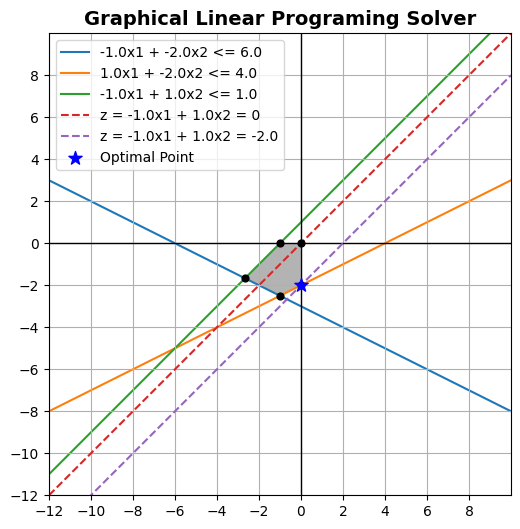

In [7]:
graph_lp = GraphLinearProgram(df)
plot = graph_lp.plot_graph()
#convert plot to img and display